In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
from order_book import *
from ml import *
from ml_models_pt import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [117]:
bucket_snapshots = load_as_bucket_snapshots(
    folder = 'data/',
    contract = 'CAKEUSDT',
    start_date = datetime(2025, 4, 1),
    end_date = datetime(2025, 4, 10),
    td = timedelta(seconds=10),
    num_buckets = 10,
    bucket_size = 0.01)

2025-04-01
2025-04-02
2025-04-03
2025-04-04
2025-04-05
2025-04-06
2025-04-07
2025-04-08
2025-04-09
2025-04-10


In [357]:
X_data, X_aux, Y_data = build_bucket_data_set(
    bucket_snapshots=bucket_snapshots,
    horizon=6,
    window_len=50,
    steps_between=10)

In [358]:
train_split = int(len(X_data) * 0.8)
x_train, x_train_aux, y_train = X_data[:train_split], X_aux[:train_split], Y_data[:train_split]
x_val, x_val_aux, y_val = X_data[train_split:], X_aux[train_split:], Y_data[train_split:]

### Normalize Data

In [254]:
def signed_log_transform(x):
    """Apply sign-preserving log transformation to data."""
    # Get the sign of the data
    signs = np.sign(x)
    log_abs = np.log1p(np.abs(x))
    return signs * log_abs

In [255]:
x_train = signed_log_transform(x_train)
x_val = signed_log_transform(x_val)

In [360]:
target_std = np.std(y_train, axis=0)

y_train = y_train / target_std
y_val = y_val / target_std

In [361]:
# remove outliers
keep = (y_train < 4) & (y_train > -4)
y_train = y_train[keep]
x_train = x_train[keep]
x_train_aux = x_train_aux[keep]

In [347]:
# Compute mean and std along the samples axis (axis 0)
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)

# Normalize while preserving 3D structure
x_train = (x_train - train_mean) / train_std
x_val = (x_val - train_mean) / train_std

### Visualization

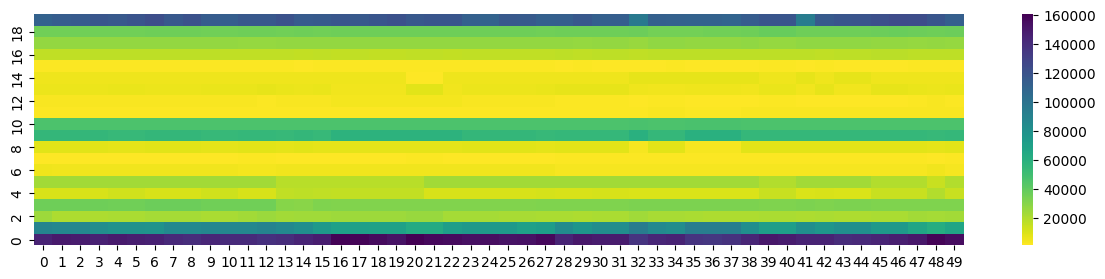

In [362]:
plt.figure(figsize=(15, 3))
sns.heatmap(x_train[300].T, cmap='viridis_r')#, vmin=-5, vmax=5)
plt.gca().invert_yaxis()
plt.show()

In [363]:
print(f"up-trends: {(y_val < 0).sum()/len(y_val)}")
print(f"down-trends: {(y_val > 0).sum()/len(y_val)}")

up-trends: 0.40669014084507044
down-trends: 0.42488262910798125


### Model Training

In [364]:
train_dataset = OrderBookDataset(x_train, x_train_aux, y_train)
val_dataset = OrderBookDataset(x_val, x_val_aux, y_val)

In [365]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [366]:
model = OrderBookModel(
    input_size=50*20, 
    aux_size=50*5,
    hidden_size=128, 
    output_size=1, 
    dropout_rate=0.0
)

In [352]:
class SimpleOverfitModel(nn.Module):
    def __init__(self, input_size=50*20, aux_size=50*5, output_size=1):
        super(SimpleOverfitModel, self).__init__()
        total_features = input_size + aux_size
        self.net = nn.Sequential(
            nn.Linear(total_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )
        
    def forward(self, x, aux_features):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)
        aux_features = aux_features.view(batch_size, -1)
        combined = torch.cat([x, aux_features], dim=1)
        output = self.net(combined)
        return output.view(batch_size, 1, -1)

In [367]:
#model = SimpleOverfitModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [368]:
# Train the model
trained_model, losses = train_model(model, train_loader, criterion, optimizer, num_epochs=10)

/opt/anaconda3/envs/trading/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/anaconda3/envs/trading/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Loss: 0.6962
Epoch 2/10, Loss: 0.6956
Epoch 3/10, Loss: 0.6959
Epoch 4/10, Loss: 0.6954
Epoch 5/10, Loss: 0.6951
Epoch 6/10, Loss: 0.6964
Epoch 7/10, Loss: 0.6951
Epoch 8/10, Loss: 0.6950
Epoch 9/10, Loss: 0.6954
Epoch 10/10, Loss: 0.6954


Processing 1704 samples...

Confusion Matrix (% of Total Samples):
┌────────────┬─────────────────┬─────────────────┬─────────────┐
│            │ Predicted Down  │  Predicted Up   │    Total    │
├────────────┼─────────────────┼─────────────────┼───────── ───┤
│ Actual Down│      16.0%      │      32.9%      │    48.9%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Actual Up  │      13.8%      │      37.3%      │    51.1%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Total      │      29.8%      │      70.2%      │   100.0%    │
└────────────┴─────────────────┴─────────────────┴─────────────┘

Overall accuracy: 53.4%

Trend Prediction:
Correct trends: 756/1417 (53.35%)
Up trend accuracy:   73.07%
Down trend accuracy: 32.76%


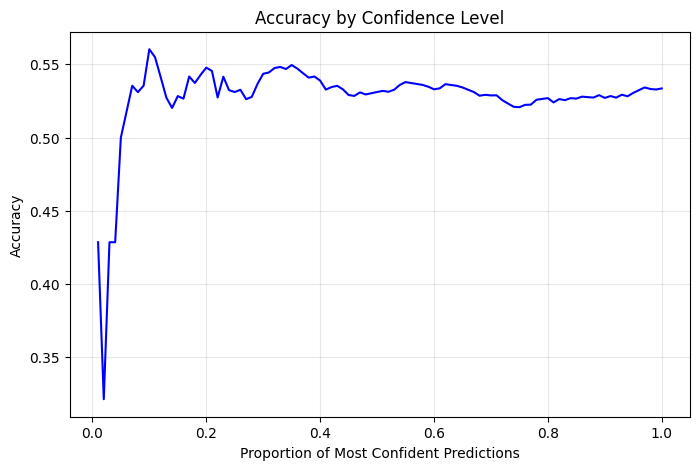

In [369]:
# Evaluate with val data
y_pred_val = evaluate_trend_prediction(trained_model, x_val, x_val_aux, y_val)

Processing 6780 samples...

Confusion Matrix (% of Total Samples):
┌────────────┬─────────────────┬─────────────────┬─────────────┐
│            │ Predicted Down  │  Predicted Up   │    Total    │
├────────────┼─────────────────┼─────────────────┼───────── ───┤
│ Actual Down│       0.0%      │      50.7%      │    50.7%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Actual Up  │       0.0%      │      49.3%      │    49.3%    │
├────────────┼─────────────────┼─────────────────┼─────────────┤
│ Total      │       0.0%      │     100.0%      │   100.0%    │
└────────────┴─────────────────┴─────────────────┴─────────────┘

Overall accuracy: 49.3%

Trend Prediction:
Correct trends: 2561/5196 (49.29%)
Up trend accuracy:   100.00%
Down trend accuracy: 0.00%


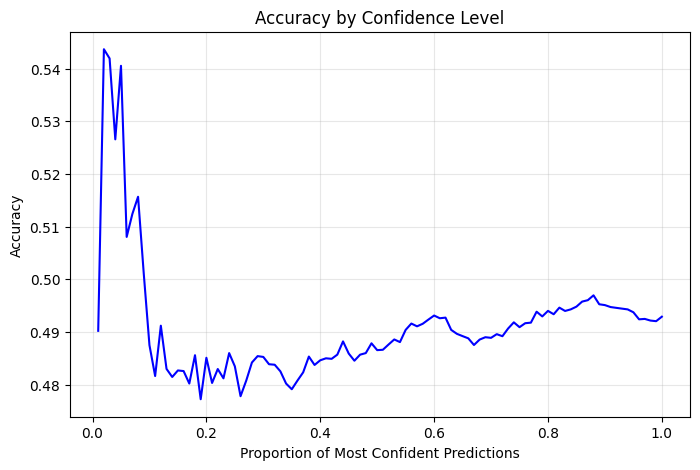

In [328]:
# Evaluate with your test data
y_pred_train = evaluate_trend_prediction(trained_model, x_train, x_train_aux, y_train)